# 1. Introduction to the problem

NIH has huge collection of 112.000 Chest X-ray images from 30,000 unique patients and need a way to accurately classify Chest X-rays using computers. They have labelled the images using NLP into 15 classes (Disease types). We need to develop a method or a model to classify these X-rays into 15 classes with minimum error rate.

Dataset is NIH Chest X-ray Dataset from Kaggle website.

Source: Full dataset 112,000 images -https://www.kaggle.com/nih-chest-xrays/data

Before going with the full dataset went ahead to test the process with a sample dataset.

Source: Sample dataset 5606 images (5% of full data)-https://www.kaggle.com/nih-chest-xrays/sample

Reading X-rays:
> In an X-ray, tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb the X-rays and appear white in the image. In short –

> Black = Air

> White = Bone

> Grey = Tissue or Fluid

> Now let’s look at an image from the data set with lung opacities. Opacity here is loosely defined as any area of the chest x-ray which appears whiter than it should be as shown below. These areas look like “fuzzy clouds”.
> ![](http://)From: https://springml.com/2019/04/06/pneumonia-detection-using-retina-net/

There are 14 Lung diseases in this dataset.

Hernia - 13 images
Pneumonia - 62 images
Fibrosis - 84 images
Edema - 118 images
Emphysema - 127 images
Cardiomegaly - 141 images
Pleural_Thickening - 176 images
Consolidation - 226 images
Pneumothorax - 271 images
Mass - 284 images
Nodule - 313 images
Atelectasis - 508 images
Effusion - 644 images
Infiltration - 967 images
No Finding - 3044 images

### Need of DataScience to be applied for Healthcare Industry
> Healthcare Needs AI to Scale
> Today, only about **10% of 7B population in the world have access to good healthcare** service, and half of the world don’t even access to essential health services. Even among the developed countries, healthcare system is under strain, with rising cost and long wait time. **To train up enough physicians and care providers **for the growing demands within a short period of time is impractical,** if not impossible. The solution has to involve technological breakthroughs.**

From: https://towardsdatascience.com/can-machine-learning-read-chest-x-rays-like-radiologists-part-1-7182cf4b87ff

**Why Medical images are most challenging to work with?

Most existing computer vision neural networks are designed for colorful natural images and takes advantage of the rich textures present in them. This makes it hard to directly apply off-the-shelf solutions on CXRs (Chest X-Rays).

Data limitations:
1. The image labels are NLP extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%.-----This limits our Final TEST accuracy to some extent.
2. Very limited numbers of disease region bounding boxes (See BBox_list_2017.csv)
3. CXRs radiology reports are not anticipated to be publicly shared. Parties who use this public dataset are encouraged to share their “updated” image labels and/or new bounding boxes in their own studied later, maybe through manual annotation

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

%matplotlib inline
from skimage.transform import resize
import seaborn as sns
from collections import Counter
import os
from glob import iglob, glob

In [15]:
# Import various componenets for model building

import tensorflow as tf
import keras

# Import the backend
from keras import backend as K

from numpy.random import seed
seed(4)
from tensorflow import set_random_seed
set_random_seed(4)
tf.__version__

'1.14.0'

In [16]:
keras.__version__

'2.2.4'

In [17]:
# Read data from CSV into dataframe
dataframe = pd.read_csv(r'/kaggle/input/sample_labels.csv')

# copy paths of the image files into a list to insert later into dataframe
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/kaggle/input/sample/images/', '*.png'))}

In [18]:
print ("No.of image paths retrieved:", len (all_image_paths))

No.of image paths retrieved: 5606


In [19]:
dataframe.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [20]:
# Deleting unnecessary columns
dataframe = dataframe.iloc[:,0:2 ]

# Placing path in the dataframe column
dataframe['path'] = dataframe['Image Index'].map(all_image_paths.get)
dataframe.shape

(5606, 3)

In [21]:
dataframe.head()

,Image Index,Finding Labels,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,/kaggle/input/sample/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,/kaggle/input/sample/images/00000013_026.png
2,00000017_001.png,No Finding,/kaggle/input/sample/images/00000017_001.png
3,00000030_001.png,Atelectasis,/kaggle/input/sample/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,/kaggle/input/sample/images/00000032_001.png


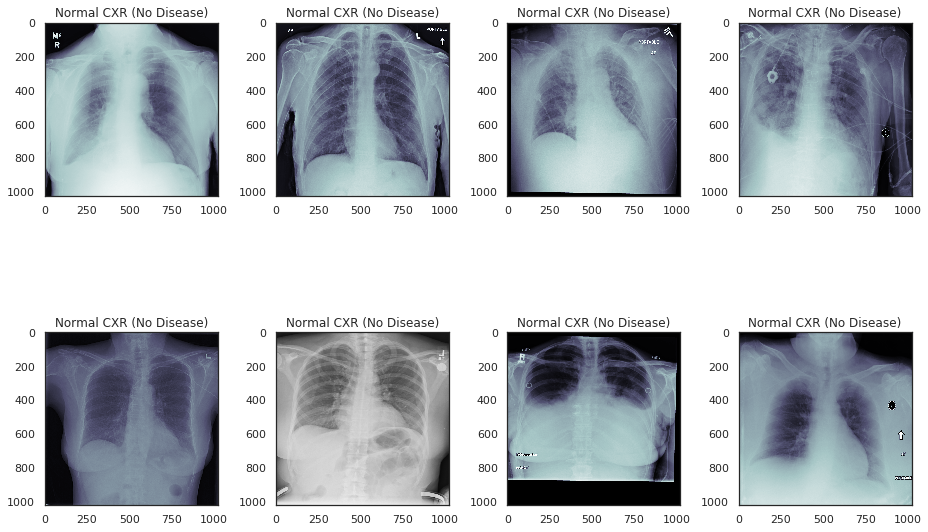

In [22]:
# Displaying 8 CXRs of No Disease or No Finding class
# Observe the variety in each class
fig, axs = plt.subplots(2, 4, figsize = (13, 13))
for (i, ax) in zip(range(8), axs.flat): 
    image = imread(dataframe.path[dataframe['Finding Labels']=='No Finding'][0:20].values[i])
    ax.set_title("Normal CXR (No Disease)")
    ax.imshow(image, cmap='bone')
    plt.tight_layout()

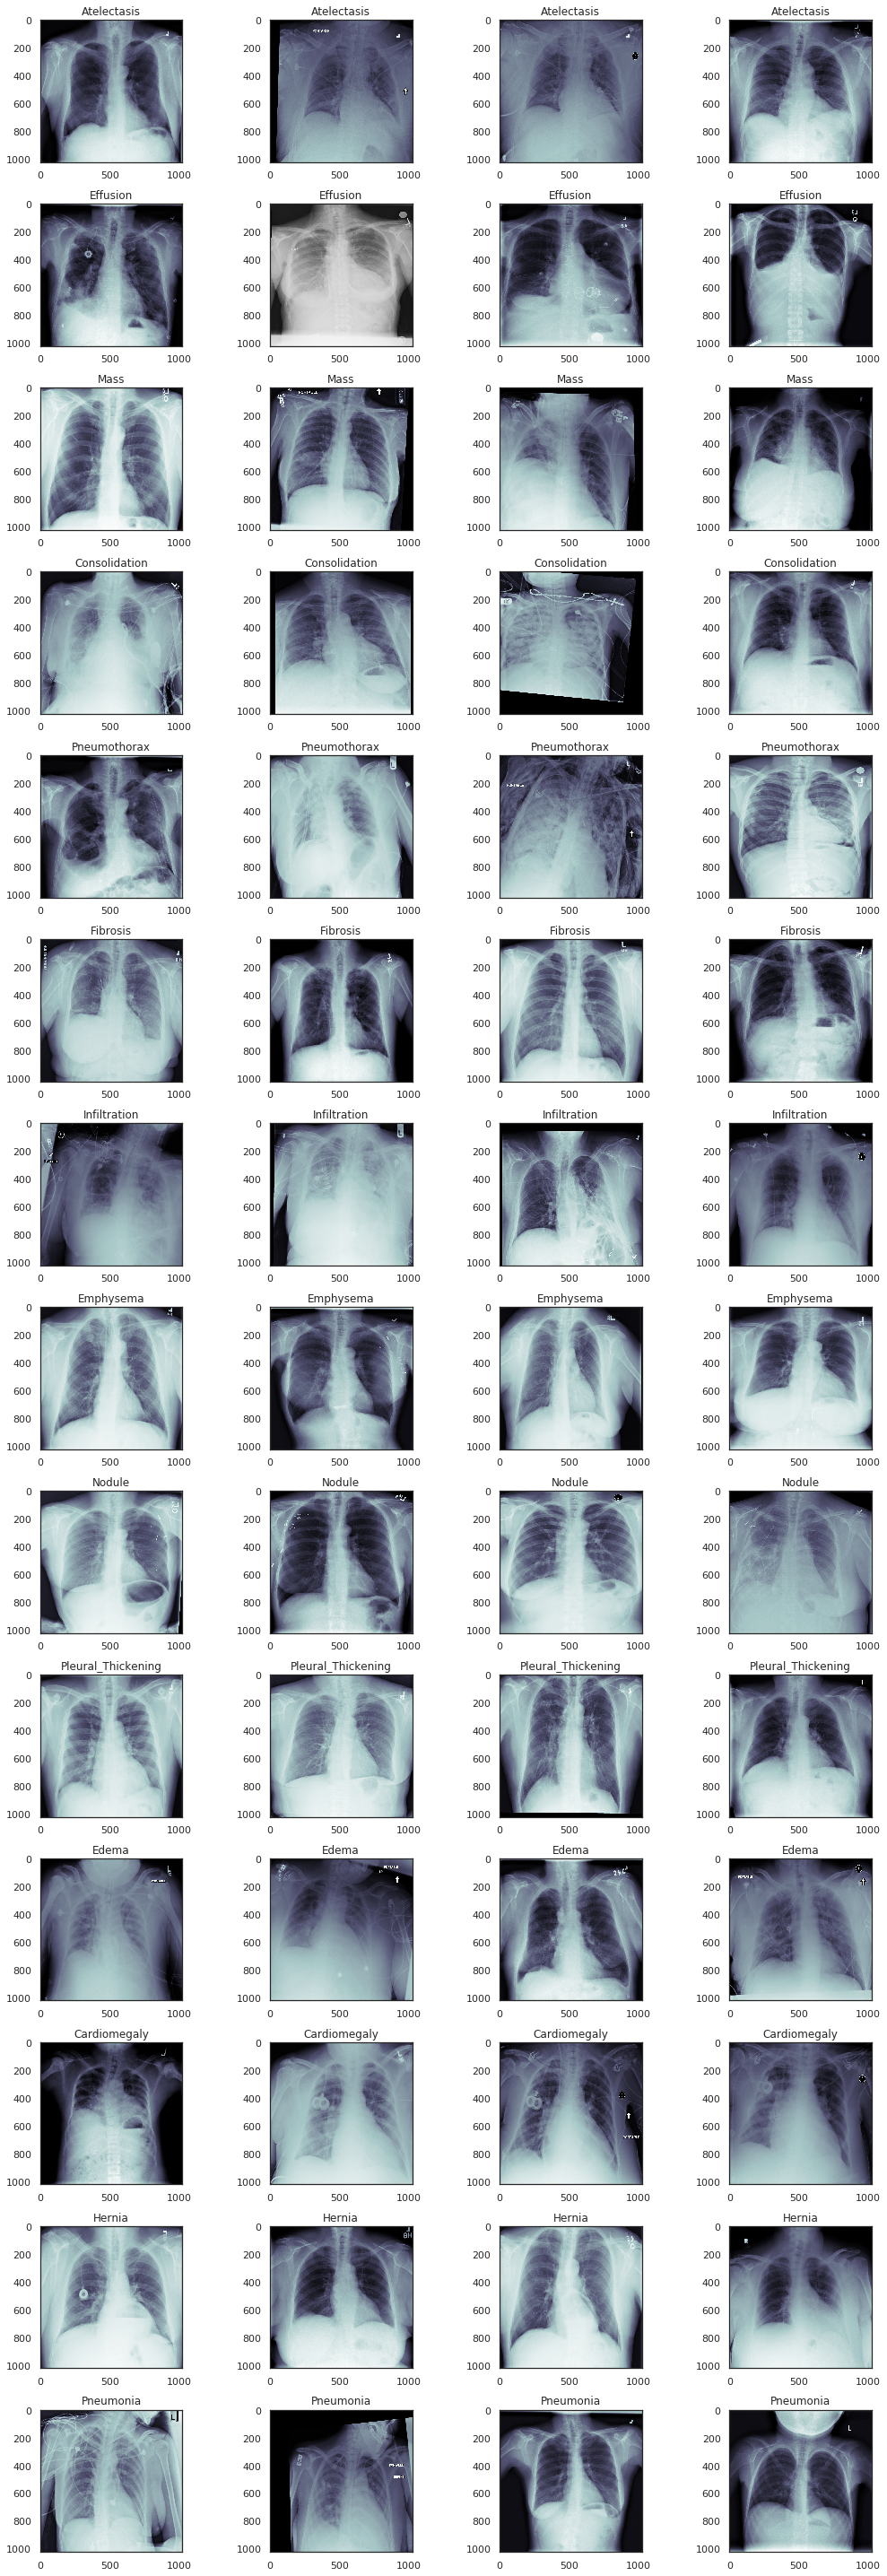

In [23]:
# Displaying 4 CXRs in each row for each class (14 classes) of disease
path_list = []
image_labels = []
slicedf = dataframe[dataframe['Finding Labels']!='No Finding']
labels = [item for item in slicedf['Finding Labels'].unique() if  '|' not in item ]

for eachClass in labels:
      for i in range(4):
        path_list.append(dataframe.path[dataframe['Finding Labels']==eachClass][0:4].values[i])
        image_labels.append(eachClass)        
fig, axs = plt.subplots(14, 4, figsize=(15, 40))
i=0
for (label, ax) in zip(image_labels, axs.flat):   
        image = imread(path_list[i])
        ax.set_title(label)
        ax.imshow(image, cmap='bone')
        plt.tight_layout()
        i+=1

#### Multi Label Multi Class problem

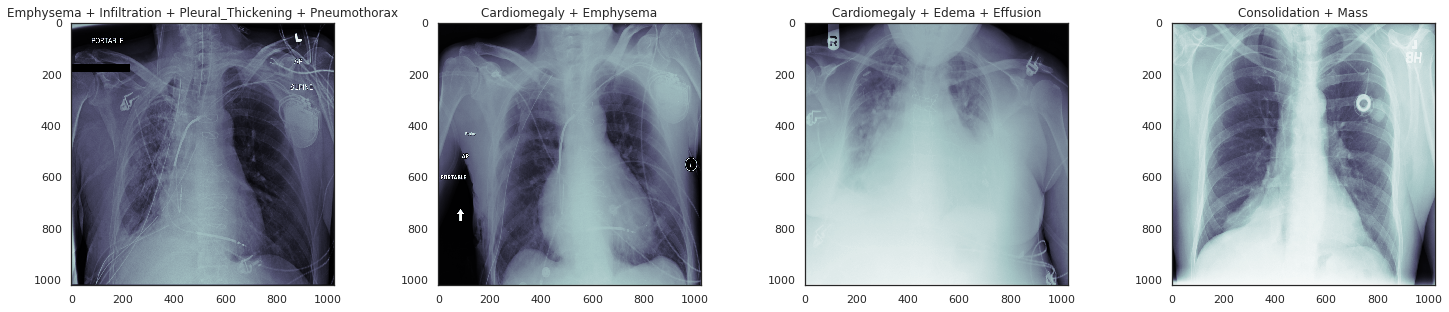

In [24]:
# Displaying CXRs which have multilabel in one image.
plt.rcParams.update({'font.size': 2})
sns.set_style('white')
path_list = []
image_labels = []
for i, item in enumerate(dataframe['Finding Labels']):
    if len(item.split("|")) >= 2:
        path_list.append(dataframe.loc[i, 'path'])
        image_labels.append(' + '.join(dataframe.loc[i, 'Finding Labels'].split('|')))
    if len(path_list)>3:
        break

fig, axs = plt.subplots(1, 4, figsize=(20, 8))
i=0
for (label, ax) in zip(image_labels, axs.flat):   
        image = imread(path_list[i])
        ax.set_title(label)
        ax.imshow(image, cmap='bone')
        plt.tight_layout()
        i+=1

In [25]:
# True counts per 15 classes only out of a total of 6978 instances of each label
counts = dataframe['Finding Labels'].apply(lambda x:x.split("|"))

Class_counts = dict(Counter([item for value in counts for item in value ]))
Class_counts

{'Emphysema': 127,
 'Infiltration': 967,
 'Pleural_Thickening': 176,
 'Pneumothorax': 271,
 'Cardiomegaly': 141,
 'No Finding': 3044,
 'Atelectasis': 508,
 'Edema': 118,
 'Effusion': 644,
 'Consolidation': 226,
 'Mass': 284,
 'Nodule': 313,
 'Fibrosis': 84,
 'Pneumonia': 62,
 'Hernia': 13}

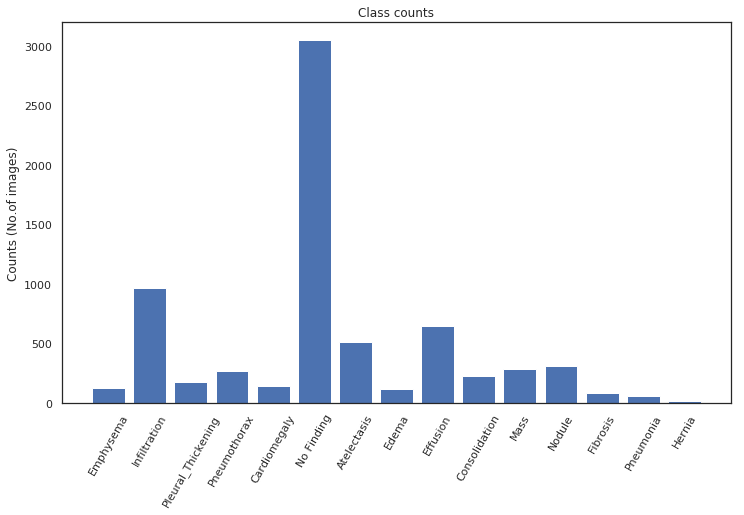

In [26]:
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('white')
plt.bar(range(len(Class_counts)), Class_counts.values(), align='center')
plt.title("Class counts")
plt.ylabel("Counts (No.of images)")
plt.xticks(range(len(Class_counts)), list(Class_counts.keys()), rotation=60)
plt.show()

# 2. Challenge I Classification - Solution: Binary

### Creating two classes No Disease and Disease. All the 14 classes with disease are consdiered as one class called 'Disease'. And we can run the model to experiment if it can distinguish Disease and No Disease CXRs.

In [27]:
# Creating Binary fields
dataframe_No_disease = dataframe[dataframe['Finding Labels'] == 'No Finding']
dataframe_disease = dataframe[dataframe['Finding Labels'] != 'No Finding']
dataframe_No_disease['Binary_class'] = 'No_Disease'
dataframe_disease['Binary_class'] = 'Disease'
dataframe = pd.concat([dataframe_No_disease, dataframe_disease ], axis=0)
dataframe = dataframe.sample(frac=1, replace=False, random_state=4)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [28]:
dfnew=dataframe['Binary_class'].str.get_dummies()
dataframe=dataframe.assign(Disease=dfnew['Disease'], No_Disease=dfnew['No_Disease'])
dataframe['disease_vec'] = dataframe['Disease'].apply(lambda x: [x, 1-x])

In [29]:
dataframe = dataframe.sample(frac=1, replace=False, random_state=6)
dataframe.reset_index(drop=True, inplace=True)
dataframe.shape

(5606, 7)

In [30]:
dataframe.head()

,Image Index,Finding Labels,path,Binary_class,Disease,No_Disease,disease_vec
0,00015647_020.png,No Finding,/kaggle/input/sample/images/00015647_020.png,No_Disease,0,1,"[0, 1]"
1,00005746_003.png,Infiltration,/kaggle/input/sample/images/00005746_003.png,Disease,1,0,"[1, 0]"
2,00000612_000.png,No Finding,/kaggle/input/sample/images/00000612_000.png,No_Disease,0,1,"[0, 1]"
3,00020857_002.png,Atelectasis,/kaggle/input/sample/images/00020857_002.png,Disease,1,0,"[1, 0]"
4,00012146_006.png,No Finding,/kaggle/input/sample/images/00012146_006.png,No_Disease,0,1,"[0, 1]"


In [31]:
#Taking a subset of the data since the models are taking long time to run and out of memory or resource errors.
data_df = dataframe.sample(frac=0.2, replace=False, random_state=6)
data = data_df['path'].values.tolist()

In [ ]:
# Converting images into numpy arrays and normalization of array data

images_array = np.zeros([len(data),128,128,1])
for i, x in enumerate(data):
    image = resize(imread(x, as_gray=True), (128, 128, 1))
    images_array[i] = (image - image.min())/(image.max() - image.min())
print ("Train images processed into numpy arrays, shape is", images_array.shape)    


X = images_array.reshape(len(images_array),128*128)
Y = np.asarray(data_df['Disease'])

The Data is already to do the model fitting using the Tradditional Supervised Machine learning models...after which I plan to implement Convolutional neural networks.